# Yoga Pose Classification

## 1. Overview

### 1.1 Problem Statement:

The "Yoga Pose Classification" project by ML21 aims to develop a system that accurately classifies yoga poses from pre-recorded images. With the rising interest in exercise and health, especially in Singapore's fast-paced lifestyle, there is a need for accessible platforms for citizens to exercise at home. However, the lack of readily available and affordable yoga instructors has inspired the team to incorporate human pose recognition into a web application. This application will allow individuals to practice yoga poses correctly by themselves, providing real-time feedback on their form.

### 1.2  Methodology and Metrics:

The team uses deep learning approaches, including Convolutional Neural Networks (CNNs), along with pose estimation models like MoveNet to achieve accurate pose classification. MoveNet, a real-time and accurate model, is chosen for preprocessing the images and predicting the keypoints representing human body parts. The CNN is then trained on the keypoints data to classify the yoga poses.

The project's success is measured through metrics such as accuracy, loss, and latency. The team evaluates various hyperparameters and optimization metrics to fine-tune the model and achieve optimal results.

### 1.3 Model:

The proposed model comprises a combination of MoveNet for pose estimation and a custom-designed CNN for pose classification. MoveNet detects 17 key points on the human body, converting them into a 1D array that serves as input to the CNN. The CNN classifies the poses into six different categories. The model achieves an impressive accuracy of 92.7% on the Singapore dataset with real-time inference, making it ideal for low GPU devices.

### 1.4 Hyperparameter Tuning and Comparisons

The team extensively explores hyperparameter tuning, batch sizes, and optimization metrics, aiming to improve model performance. They compare their proposed model against implementations using DenseNet and EfficientNet, demonstrating its superiority in accuracy and speed.

### 1.5 Conclusion and Future Improvements

The project's proposed system offers a valuable tool for individuals to practice yoga with proper form and achieve correct poses. The team suggests potential improvements like data augmentation and user-specific joint profiles to enhance the model's performance further. The application's scalability and inclusiveness for differently-abled individuals are also considered for future iterations.

## 2. Model: MoveNet + CNN

### 2.1 Import libraries

In [34]:
!pip install pandas
!pip install numpy

!pip install opencv-python

!pip install matplotlib

!pip install tensorflow
!pip install tensorflow_hub
!pip install scikit-learn

!pip install wget
!pip install tqdm

In [16]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
from  tqdm import tqdm
import random
import re
import shutil

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T,datasets

### 2.2 Setting up functions

#### 2.2.1 MoveNet Thunder to process images into keypoints and class csv
Loads MoveNet Thunder Model with detect function which identifies keypoints (body landmarks) and their confidence scores for the given input image.

In [2]:
import wget

# Download model from TF Hub and check out inference code from GitHub
!python -m wget -o movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person


Saved under movenet_thunder.tflite


fatal: destination path 'examples' already exists and is not an empty directory.


Draw prediction on image overlays the keypoints on the image and return the visualised image as a numpy array.

In [3]:
def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.
 
  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.
 
  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image and store as a NumPy array.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

Class to preprocess images to detect keypoints and save them with image label into csv file.

In [19]:
class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detection pose from images and save as CSV.

    Args:
      images_in_folder: Path to the folder with the input images. It should
        follow this structure:
        yoga_poses
        |__ downdog
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ goddess
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...
      images_out_folder: Path to write the images overlay with detected
        landmarks. These images are useful when you need to debug accuracy
        issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load. As preprocessing usually
        takes time, this parameter can be specified to make the reduce of the
        dataset for testing.
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)

    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

Setting custom parameters

In [5]:
is_skip_step_1 = False
use_custom_dataset = True
dataset_is_split = False

### 2.2.2 Function to train test split

Define function to split into train and test into separate directories and shuffles the images in  the class

In [6]:
def split_into_train_test(images_origin, images_dest, test_split):
  """Splits a directory of sorted images into training and test sets.

  Args:
    images_origin: Path to the directory with your images. This directory
      must include subdirectories for each of your labeled classes. For example:
      yoga_poses/
      |__ downdog/
          |______ 00000128.jpg
          |______ 00000181.jpg
          |______ ...
      |__ goddess/
          |______ 00000243.jpg
          |______ 00000306.jpg
          |______ ...
      ...
    images_dest: Path to a directory where you want the split dataset to be
      saved. The results looks like this:
      split_yoga_poses/
      |__ train/
          |__ downdog/
              |______ 00000128.jpg
              |______ ...
      |__ test/
          |__ downdog/
              |______ 00000181.jpg
              |______ ...
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  """
  _, dirs, _ = next(os.walk(images_origin))

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(42)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

Function to process CSV into X and y

In [7]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

### 2.3 Process the data

#### 2.3.1 Train test split

Use the split_into_train_test function

In [8]:
if use_custom_dataset:
  # ATTENTION:
  # You must edit these two lines to match your archive and images folder name:
  # !tar -xf YOUR_DATASET_ARCHIVE_NAME.tar
  #!unzip -q archive.zip
  dataset_in = 'DATASETNEW/yoga_set'

  # You can leave the rest alone:
  if not os.path.isdir(dataset_in):
    raise Exception("dataset_in is not a valid directory")
  if dataset_is_split:
    IMAGES_ROOT = dataset_in
  else:
    dataset_out = 'split_' + dataset_in
    split_into_train_test(dataset_in, dataset_out, test_split=0.2)
    IMAGES_ROOT = dataset_out

Moved 94 of 474 from class "downdog" into test.
Moved 96 of 482 from class "goddess" into test.
Moved 96 of 483 from class "mountain" into test.
Moved 87 of 439 from class "tree" into test.
Moved 87 of 436 from class "warrior1" into test.
Moved 112 of 562 from class "warrior2" into test.
Your split dataset is in "split_DATASETNEW/yoga_set"


#### 2.3.2 Convert train and test inputs into CSVs

Preprocess the split data, to detect keypoints and save into CSV.

In [20]:
if not is_skip_step_1:
  images_in_train_folder = os.path.join(IMAGES_ROOT, 'TRAIN')
  images_out_train_folder = 'poses_images_out_train'
  csvs_out_train_path = 'train_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_train_folder,
      images_out_folder=images_out_train_folder,
      csvs_out_path=csvs_out_train_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing downdog


  0%|          | 0/380 [00:00<?, ?it/s]

Preprocessing goddess


  0%|          | 0/386 [00:00<?, ?it/s]

Preprocessing mountain


  0%|          | 0/387 [00:00<?, ?it/s]

c:\Users\jonas\anaconda3\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\jonas\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Preprocessing tree


  0%|          | 0/352 [00:00<?, ?it/s]

Preprocessing warrior1


  0%|          | 0/349 [00:00<?, ?it/s]

Preprocessing warrior2


  0%|          | 0/450 [00:00<?, ?it/s]

Skipped split_DATASETNEW/yoga_set\TRAIN\downdog\149467333_112436647523829_5219800997207869671_n.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TRAIN\downdog\149498980_827814177799361_9132959732694816091_n.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TRAIN\downdog\150375836_2946820022241483_367474647503968400_n.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TRAIN\downdog\150799970_242464284092778_3841585113128687343_n.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TRAIN\downdog\150995203_1592000744524308_8877415778008419274_n.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TRAIN\downdog\151144351_420531532352410_1155630266119747922_n.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TRAIN\downdog\151202012_211914803961227_2976108343785902041_n.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TRAIN\downdog

In [21]:
if not is_skip_step_1:
  images_in_test_folder = os.path.join(IMAGES_ROOT, 'TEST')
  images_out_test_folder = 'poses_images_out_test'
  csvs_out_test_path = 'test_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_test_folder,
      images_out_folder=images_out_test_folder,
      csvs_out_path=csvs_out_test_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing downdog


  0%|          | 0/94 [00:00<?, ?it/s]

Preprocessing goddess


  0%|          | 0/96 [00:00<?, ?it/s]

Preprocessing mountain


  0%|          | 0/96 [00:00<?, ?it/s]

Preprocessing tree


  0%|          | 0/87 [00:00<?, ?it/s]

Preprocessing warrior1


  0%|          | 0/87 [00:00<?, ?it/s]

Preprocessing warrior2


  0%|          | 0/112 [00:00<?, ?it/s]

Skipped split_DATASETNEW/yoga_set\TEST\downdog\133.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TEST\downdog\151328400_114472073971411_4525358269707391269_n.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TEST\downdog\Dogpose_6.png. Image isn't in RGB format.
Skipped split_DATASETNEW/yoga_set\TEST\downdog\WhatsApp Image 2021-02-25 at 12.06.39 AM (1).jpeg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TEST\downdog\WhatsApp Image 2021-02-25 at 12.06.42 AM.jpeg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TEST\downdog\downdog_3.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TEST\downdog\downdog_62.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TEST\goddess\131.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TEST\goddess\48.jpg. No pose was confidentlly detected.
Skipped split_DATASETNEW/yoga_set\TEST\goddess\

Process the csv with keypoints and class into X and y

In [22]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [23]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

#### 2.4 Normalising the data

Create a pose estimation pipeline to convert detected landmarks into a pose embedding

1. Get the centre point between two body parts
2. Use the centre point to get pose size
    - Get torso size = shoulders - hip
    - Find the distance between part to centre
    - Get max_distance
    - Return max(torso * multiplier or max distance)
        - strikes a balance between being informative based on the torso size and being large enough to cover the entire pose
3. Normalize each landmark by their pose size
4. Turn normalized array into an embedding by flattening it into a vector

In [24]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

### 2.5 Model Function

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

In [26]:
def train_test_draw(model,modelName,epoch,batch):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Add a checkpoint callback to store the checkpoint that has the highest
    # validation accuracy.
    checkpoint_path = "weights.best.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
    earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                patience=30)

    # Start training
    history = model.fit(X_train, y_train,
                        epochs=epoch,
                        batch_size=batch,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpoint, earlystopping])

    # Visualize the training history (Accuracy subplot)
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, subplot position 1
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['TRAIN', 'VAL'], loc='lower right')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Visualize the validation loss (Loss subplot)
    plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot position 2
    epochs = range(len(acc))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)

    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()

    loss, acc = model.evaluate(X_test, y_test)
    print(f'Validation loss: {loss}\nValidation accuracy: {acc}')

    # Classify pose in the TEST dataset using the trained model
    y_pred = model.predict(X_test)

    # Convert the prediction result to class name
    y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
    y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

    # Plot the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    plot_confusion_matrix(cm,
                        class_names,
                        title ='Confusion Matrix of Pose Classification Model')

    # Print the classification report
    print('\nClassification Report:\n', classification_report(y_true_label,
                                                            y_pred_label))

    model.save(modelName)

### 2.6 CNN Model

Model with landmarks_to_embedding function

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 17, 3)                0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 17, 2)                0         ['reshape[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpL  (None, 2)                    0         ['tf.__operators__.getitem

c:\Users\jonas\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


103/108 [===========================>..] - ETA: 0s - loss: 1.2780 - accuracy: 0.4921
Epoch 2: val_accuracy improved from 0.43934 to 0.68197, saving model to weights.best.hdf5
108/108 [==============================] - 0s 5ms/step - loss: 1.2681 - accuracy: 0.4942 - val_loss: 1.0843 - val_accuracy: 0.6820
Epoch 3/200
108/108 [==============================] - ETA: 0s - loss: 1.0814 - accuracy: 0.5824
Epoch 3: val_accuracy improved from 0.68197 to 0.72459, saving model to weights.best.hdf5
108/108 [==============================] - 0s 4ms/step - loss: 1.0814 - accuracy: 0.5824 - val_loss: 0.9179 - val_accuracy: 0.7246
Epoch 4/200
104/108 [===========================>..] - ETA: 0s - loss: 0.9703 - accuracy: 0.6274
Epoch 4: val_accuracy improved from 0.72459 to 0.78689, saving model to weights.best.hdf5
108/108 [==============================] - 1s 5ms/step - loss: 0.9698 - accuracy: 0.6270 - val_loss: 0.8216 - val_accuracy: 0.7869
Epoch 5/200
 94/108 [=========================>....] - ETA

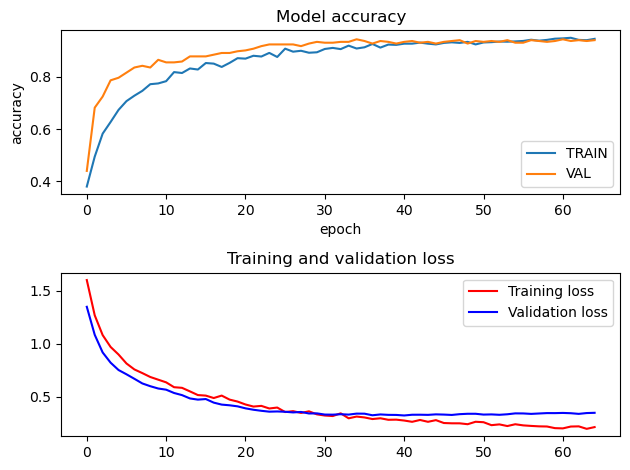

16/16 [==============================] - 0s 3ms/step - loss: 0.3088 - accuracy: 0.9277
Validation loss: 0.308819442987442
Validation accuracy: 0.927734375
16/16 [==============================] - 0s 3ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

     downdog       0.99      0.99      0.99        87
     goddess       0.88      0.93      0.90        91
    mountain       0.98      0.88      0.93        73
        tree       0.91      0.97      0.94        80
    warrior1       0.86      0.91      0.89        77
    warrior2       0.96      0.88      0.92       104

    accuracy                           0.93       512
   macro avg       0.93      0.93      0.93       512
weighted avg       0.93      0.93      0.93       512

INFO:tensorflow:Assets written to: base_cnn\assets


INFO:tensorflow:Assets written to: base_cnn\assets


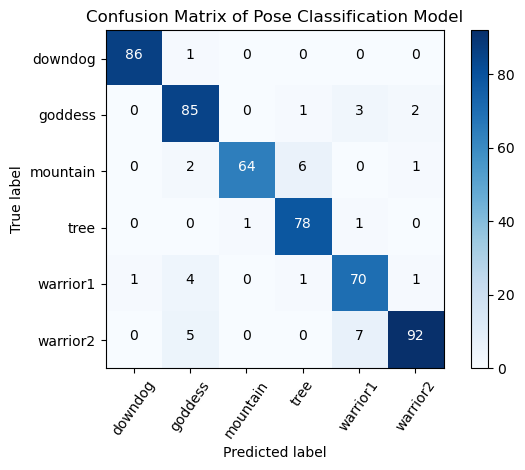

In [27]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

train_test_draw(model,"base_cnn",200,16)

### 2.6 Hyperparameter Tuning

#### 2.6.1 Using L2 regularization to normalize data insteasd

Model that uses L2 regularization

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               13312     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                                 
Total params: 178566 (697.52 KB)
Trainable params: 178566 (697.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
 98/

c:\Users\jonas\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/108 [===========================>..] - ETA: 0s - loss: 2.2924 - accuracy: 0.7215
Epoch 2: val_accuracy improved from 0.76721 to 0.79344, saving model to weights.best.hdf5
108/108 [==============================] - 1s 6ms/step - loss: 2.2648 - accuracy: 0.7198 - val_loss: 1.5468 - val_accuracy: 0.7934
Epoch 3/200
104/108 [===========================>..] - ETA: 0s - loss: 1.5476 - accuracy: 0.7849
Epoch 3: val_accuracy improved from 0.79344 to 0.88852, saving model to weights.best.hdf5
108/108 [==============================] - 1s 6ms/step - loss: 1.5306 - accuracy: 0.7871 - val_loss: 1.1932 - val_accuracy: 0.8885
Epoch 4/200
 99/108 [==========================>...] - ETA: 0s - loss: 1.2182 - accuracy: 0.8441
Epoch 4: val_accuracy did not improve from 0.88852
108/108 [==============================] - 1s 5ms/step - loss: 1.2077 - accuracy: 0.8469 - val_loss: 1.2627 - val_accuracy: 0.8393
Epoch 5/200
 98/108 [==========================>...] - ETA: 0s - loss: 1.2397 - accuracy: 0.8265


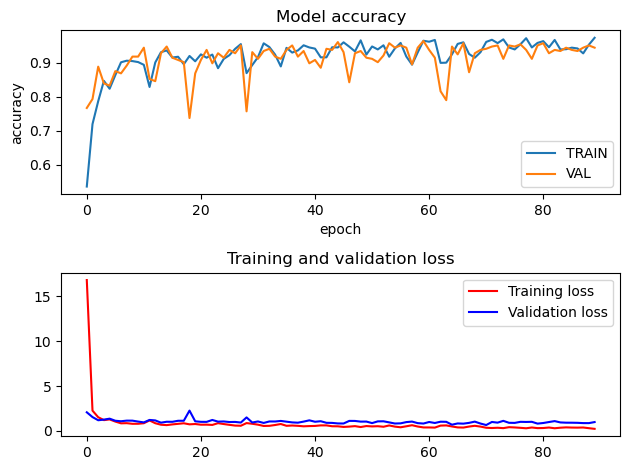

16/16 [==============================] - 0s 4ms/step - loss: 0.5146 - accuracy: 0.9355
Validation loss: 0.5145676732063293
Validation accuracy: 0.935546875
16/16 [==============================] - 0s 3ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

     downdog       0.96      1.00      0.98        87
     goddess       0.86      0.98      0.92        91
    mountain       0.96      0.89      0.92        73
        tree       0.96      0.96      0.96        80
    warrior1       0.95      0.95      0.95        77
    warrior2       0.95      0.85      0.89       104

    accuracy                           0.94       512
   macro avg       0.94      0.94      0.94       512
weighted avg       0.94      0.94      0.94       512

INFO:tensorflow:Assets written to: l2_reg\assets


INFO:tensorflow:Assets written to: l2_reg\assets


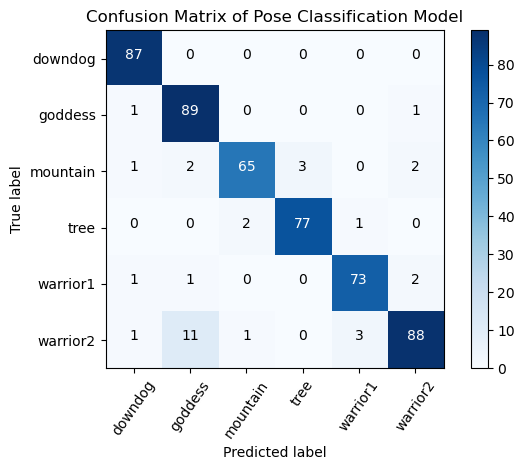

In [28]:
model = tf.keras.Sequential(
        [tf.keras.layers.Input(shape=(51,))]
    )
dense_neurons=[256, 256, 256, 128]
for n_neurons in dense_neurons:
        model.add(tf.keras.layers.Dense(
            n_neurons, activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001))
        )

model.add(tf.keras.layers.Dense(6, activation='softmax'))

model.summary()

train_test_draw(model,"l2_reg",200,16)

#### 2.6.2 Changing Batch Number

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 17, 3)                0         ['input_3[0][0]']             
                                                                                                  
 tf.__operators__.getitem_1  (None, 17, 2)                0         ['reshape_1[0][0]']           
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.compat.v1.gather_9 (TFO  (None, 2)                    0         ['tf.__operators__.getit

c:\Users\jonas\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/54 [========================>.....] - ETA: 0s - loss: 1.4798 - accuracy: 0.4187
Epoch 2: val_accuracy improved from 0.39344 to 0.47213, saving model to weights.best.hdf5
54/54 [==============================] - 0s 6ms/step - loss: 1.4680 - accuracy: 0.4153 - val_loss: 1.3076 - val_accuracy: 0.4721
Epoch 3/200
46/54 [========================>.....] - ETA: 0s - loss: 1.2950 - accuracy: 0.4715
Epoch 3: val_accuracy improved from 0.47213 to 0.54426, saving model to weights.best.hdf5
54/54 [==============================] - 0s 6ms/step - loss: 1.2916 - accuracy: 0.4675 - val_loss: 1.1683 - val_accuracy: 0.5443
Epoch 4/200
46/54 [========================>.....] - ETA: 0s - loss: 1.1979 - accuracy: 0.5265
Epoch 4: val_accuracy improved from 0.54426 to 0.60984, saving model to weights.best.hdf5
54/54 [==============================] - 0s 6ms/step - loss: 1.1871 - accuracy: 0.5307 - val_loss: 1.0630 - val_accuracy: 0.6098
Epoch 5/200
45/54 [========================>.....] - ETA: 0s - loss: 1

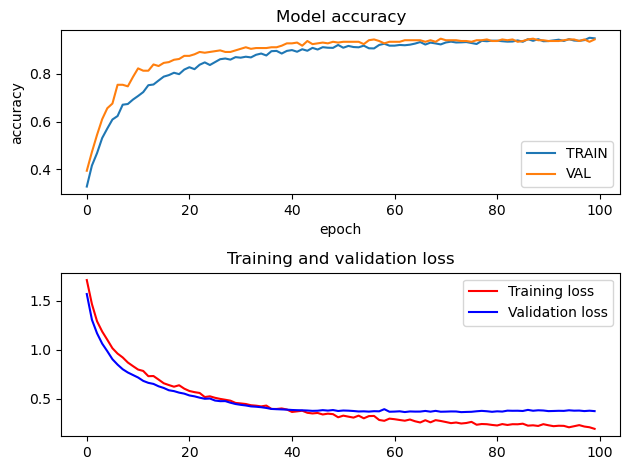

16/16 [==============================] - 0s 3ms/step - loss: 0.3192 - accuracy: 0.9297
Validation loss: 0.3192019760608673
Validation accuracy: 0.9296875
16/16 [==============================] - 0s 2ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

     downdog       0.98      1.00      0.99        87
     goddess       0.93      0.90      0.92        91
    mountain       0.97      0.90      0.94        73
        tree       0.92      0.96      0.94        80
    warrior1       0.85      0.92      0.88        77
    warrior2       0.94      0.89      0.92       104

    accuracy                           0.93       512
   macro avg       0.93      0.93      0.93       512
weighted avg       0.93      0.93      0.93       512

INFO:tensorflow:Assets written to: base_cnn\assets


INFO:tensorflow:Assets written to: base_cnn\assets


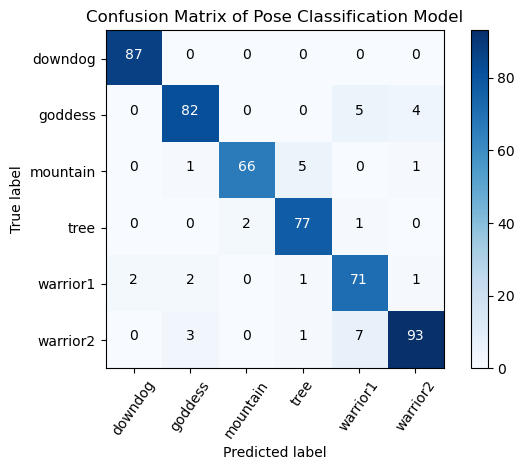

In [29]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

train_test_draw(model,"base_cnn",200,32)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape_2 (Reshape)         (None, 17, 3)                0         ['input_4[0][0]']             
                                                                                                  
 tf.__operators__.getitem_2  (None, 17, 2)                0         ['reshape_2[0][0]']           
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.compat.v1.gather_18 (TF  (None, 2)                    0         ['tf.__operators__.getit

c:\Users\jonas\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.40656
27/27 [==============================] - 0s 7ms/step - loss: 1.6488 - accuracy: 0.3950 - val_loss: 1.5414 - val_accuracy: 0.4033
Epoch 3/200
26/27 [===========================>..] - ETA: 0s - loss: 1.5026 - accuracy: 0.3984
Epoch 3: val_accuracy improved from 0.40656 to 0.41639, saving model to weights.best.hdf5
27/27 [==============================] - 0s 10ms/step - loss: 1.4983 - accuracy: 0.4014 - val_loss: 1.3789 - val_accuracy: 0.4164
Epoch 4/200
27/27 [==============================] - ETA: 0s - loss: 1.3867 - accuracy: 0.4159
Epoch 4: val_accuracy improved from 0.41639 to 0.45574, saving model to weights.best.hdf5
27/27 [==============================] - 0s 9ms/step - loss: 1.3867 - accuracy: 0.4159 - val_loss: 1.2969 - val_accuracy: 0.4557
Epoch 5/200
26/27 [===========================>..] - ETA: 0s - loss: 1.3298 - accuracy: 0.4591
Epoch 5: val_accuracy improved from 0.45574 to 0.50164, saving model to weights.best.hdf5
27/27

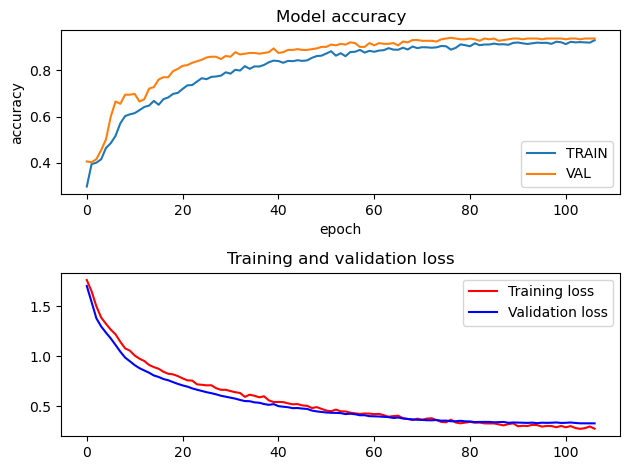

16/16 [==============================] - 0s 3ms/step - loss: 0.3307 - accuracy: 0.9297
Validation loss: 0.33067983388900757
Validation accuracy: 0.9296875
16/16 [==============================] - 0s 3ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

     downdog       0.97      1.00      0.98        87
     goddess       0.94      0.88      0.91        91
    mountain       0.97      0.89      0.93        73
        tree       0.92      0.97      0.95        80
    warrior1       0.85      0.94      0.89        77
    warrior2       0.94      0.90      0.92       104

    accuracy                           0.93       512
   macro avg       0.93      0.93      0.93       512
weighted avg       0.93      0.93      0.93       512

INFO:tensorflow:Assets written to: base_cnn\assets


INFO:tensorflow:Assets written to: base_cnn\assets


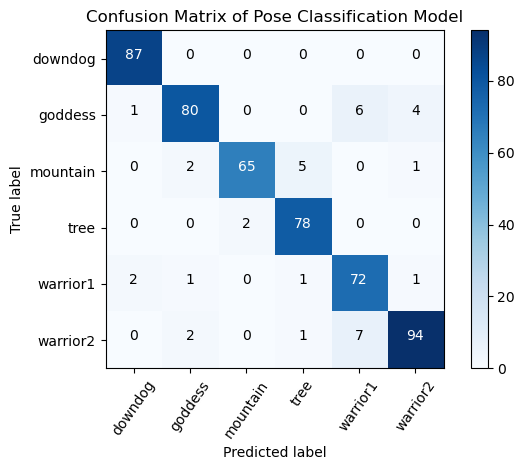

In [30]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

train_test_draw(model,"base_cnn",200,64)

### 2.7 Analysis Comparison with other SOTA models

#### 2.7.1 DenseNet

In [31]:
labels = []
images = []
asanas_name = []
images_path = []
images_pixels = []

i=0
dataset_path = './DATASETNEW/yoga_set'

for directory in os.listdir(dataset_path):
    asanas_name.append(directory)
    for img in os.listdir(os.path.join(dataset_path,directory)):  
        if len(re.findall('.png',img.lower())) != 0 or len(re.findall('.jpg',img.lower())) != 0 or len(re.findall('.jpeg',img.lower())) != 0:
            img_path = os.path.join(os.path.join(dataset_path,directory),img)
            images.append(img)
            images_path.append(img_path)
            img_pix = cv2.imread(img_path,1)
            images_pixels.append(cv2.resize(img_pix, (100,100)))
            labels.append(i)
        
    i = i+1
    
print("Total labels: ", len(labels))
print("Total images: ", len(images))
print("Total images path: ", len(images_path))
print("Total asanas: ", len(asanas_name))
print("Total images_pixels: ", len(images_pixels))

Total labels:  2885
Total images:  2885
Total images path:  2885
Total asanas:  6
Total images_pixels:  2885


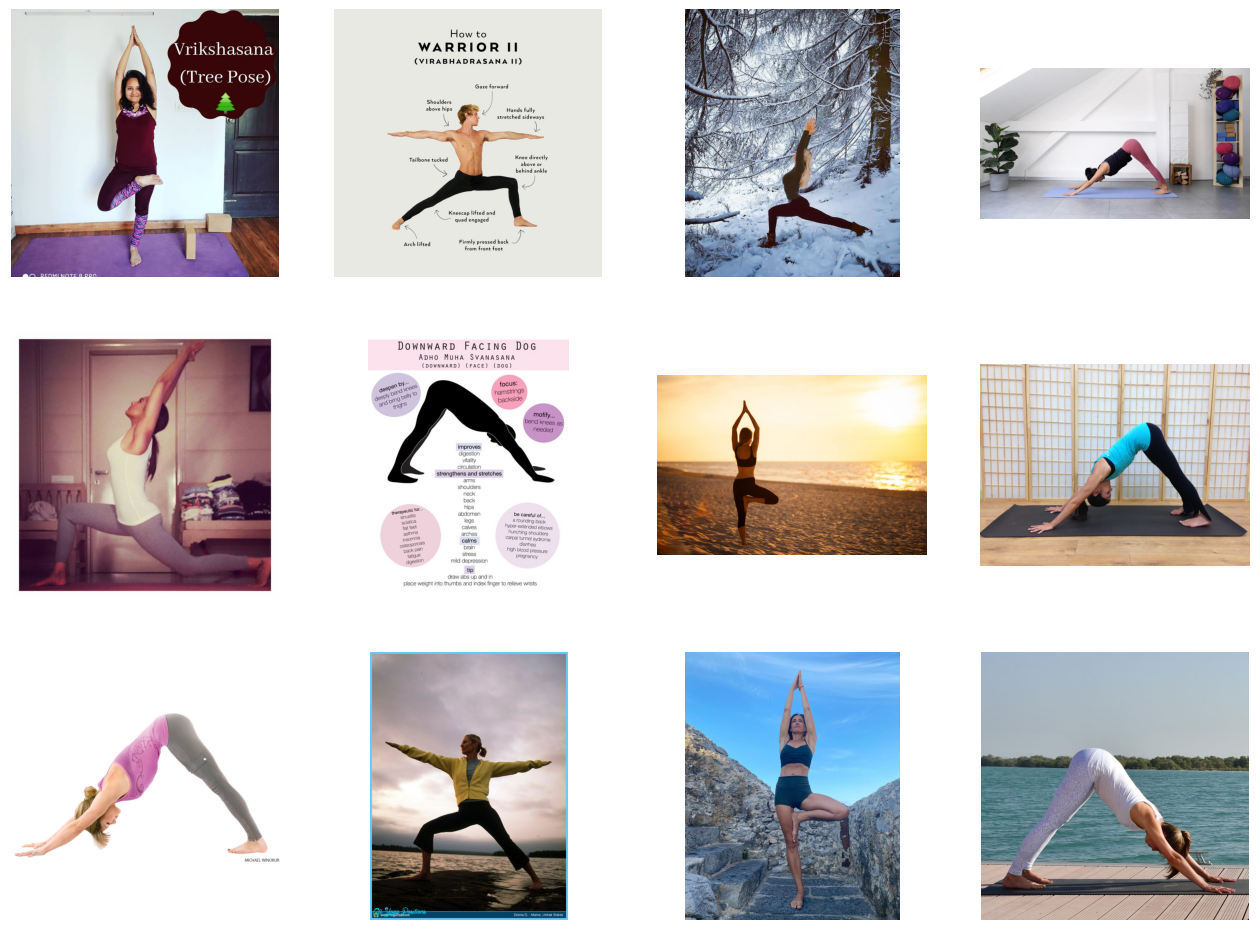

In [32]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = images_path
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [33]:
shuf = list(zip(images_pixels,labels))
random.shuffle(shuf)

train_data, labels_data = zip(*shuf)

X_data = np.array(train_data) / 255
y_data =  to_categorical(labels_data, num_classes = 107)

print("X data shape: ", X_data.shape)
print("y data shape: ", y_data.shape)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.4, random_state=101)

print("X train data : ", len(X_train))
print("X label data : ", len(X_val))
print("y train data : ", len(y_train))
print("y label data : ", len(y_val))

X data shape:  (2885, 100, 100, 3)
y data shape:  (2885, 107)
X train data :  1731
X label data :  1154
y train data :  1731
y label data :  1154


In [38]:
def train_val_draw(model,modelName,epoch,batch):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Add a checkpoint callback to store the checkpoint that has the highest
    # validation accuracy.
    checkpoint_path = "weights.best.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
    earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                patience=30)

    # Start training
    history = model.fit(X_train, y_train,
                        epochs=epoch,
                        batch_size=batch,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpoint, earlystopping])

    # Visualize the training history (Accuracy subplot)
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, subplot position 1
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['TRAIN', 'VAL'], loc='lower right')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Visualize the validation loss (Loss subplot)
    plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot position 2
    epochs = range(len(acc))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)

    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()

    loss, acc = model.evaluate(X_val,y_val)
    print(f'Validation loss: {loss}\nValidation accuracy: {acc}')

    model.save(modelName)

In [39]:
datagen = ImageDataGenerator(horizontal_flip=False,
                             vertical_flip=False,
                             rotation_range=0,
                             zoom_range=0.2,
                             width_shift_range=0,
                             height_shift_range=0,
                             shear_range=0,
                             fill_mode="nearest")

In [40]:
pretrained_model = tf.keras.applications.DenseNet121(input_shape=(100,100,3),
                                                      include_top=False,
                                                      weights='imagenet',
                                                      pooling='avg')
pretrained_model.trainable = False

Epoch 1/10
109/109 [==============================] - ETA: 0s - loss: 1.4141 - accuracy: 0.5298
Epoch 1: val_accuracy improved from -inf to 0.65858, saving model to weights.best.hdf5


c:\Users\jonas\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


109/109 [==============================] - 105s 841ms/step - loss: 1.4141 - accuracy: 0.5298 - val_loss: 0.9218 - val_accuracy: 0.6586
Epoch 2/10
109/109 [==============================] - ETA: 0s - loss: 0.8298 - accuracy: 0.7083
Epoch 2: val_accuracy improved from 0.65858 to 0.76083, saving model to weights.best.hdf5
109/109 [==============================] - 81s 748ms/step - loss: 0.8298 - accuracy: 0.7083 - val_loss: 0.6846 - val_accuracy: 0.7608
Epoch 3/10
109/109 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.7631
Epoch 3: val_accuracy improved from 0.76083 to 0.77210, saving model to weights.best.hdf5
109/109 [==============================] - 83s 763ms/step - loss: 0.6624 - accuracy: 0.7631 - val_loss: 0.6409 - val_accuracy: 0.7721
Epoch 4/10
109/109 [==============================] - ETA: 0s - loss: 0.5764 - accuracy: 0.7949
Epoch 4: val_accuracy did not improve from 0.77210
109/109 [==============================] - 82s 754ms/step - loss: 0.5764 - acc

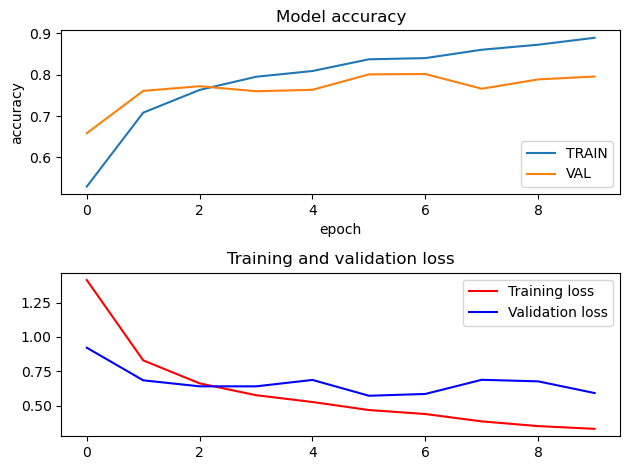

37/37 [==============================] - 21s 575ms/step - loss: 0.5920 - accuracy: 0.7955
Validation loss: 0.5919685959815979
Validation accuracy: 0.7954939603805542
INFO:tensorflow:Assets written to: densenet\assets


INFO:tensorflow:Assets written to: densenet\assets


In [41]:
pretrained_model = tf.keras.applications.DenseNet121(input_shape=(100,100,3),
                                                      include_top=False,
                                                      weights='imagenet',
                                                      pooling='avg')
pretrained_model.trainable = False

inputs = pretrained_model.input
drop_layer = tf.keras.layers.Dropout(0.25)(pretrained_model.output)
x_layer = tf.keras.layers.Dense(512, activation='relu')(drop_layer)
x_layer1 = tf.keras.layers.Dense(128, activation='relu')(x_layer)
drop_layer1 = tf.keras.layers.Dropout(0.20)(x_layer1)
outputs = tf.keras.layers.Dense(107, activation='softmax')(drop_layer1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

train_val_draw(model,"densenet",10,16)

#### 2.7.2 EfficientNet with PyTorch

In [42]:
data_dir = './DATASETNEW/yoga_set'
#print(os.listdir(data_dir))
class_name=os.listdir(data_dir)

In [43]:
class CNFG:
    epochs =20                             
    lr = 0.001                             
    batch_size = 16                        
    model_name = 'tf_efficientnet_b4_ns'    
    img_size = 224
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cpu


In [44]:
data_transform = T.Compose([
                             T.Resize(size=(CNFG.img_size,CNFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

data = datasets.ImageFolder(data_dir,       
                    transform=data_transform)
total_count = len(data)

train_count = int(0.6 * total_count) 
valid_count = int(0.3 * total_count)
test_count = total_count - train_count - valid_count
train_data, val_data, test_data = torch.utils.data.random_split(data, (train_count, valid_count, test_count))

In [45]:
trainloader = DataLoader(train_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader)))  
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:109
No. of Total examples:1732
No. of batches in validationloader:55
No. of Total examples:866
No. of batches in testloader:19
No. of Total examples:289


In [46]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CNFG.model_name,pretrained=True) #load pretrained model

#Updating the pretrained model:
for param in model.parameters():
    param.requires_grad=False

model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=107), 
)

from torchsummary import  summary
model.to(device)# move the model to GPU
summary(model,input_size=(3,224,224))

c:\Users\jonas\anaconda3\Lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
    SqueezeExcite-13         [-1, 48, 112, 112]               0
           Conv2d-14         [-1, 24, 1

In [49]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [50]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class ModelTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
        
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(outputs,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(outputs,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() 
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) 
            
            model.eval()  
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) 
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'YogaAsanas.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CNFG.lr)

trainer = ModelTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,20)

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)

print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Valid_loss decreased inf --> 1.2294938282533125
Epoch : 1 Train Loss : 1.730013 Train Acc : 0.368693
Epoch : 1 Valid Loss : 1.229494 Valid Acc : 0.565909


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Valid_loss decreased 1.2294938282533125 --> 1.1297272942282937
Epoch : 2 Train Loss : 1.110227 Train Acc : 0.594610
Epoch : 2 Valid Loss : 1.129727 Valid Acc : 0.587500


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.989256 Train Acc : 0.622133
Epoch : 3 Valid Loss : 1.130304 Valid Acc : 0.584091


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Valid_loss decreased 1.1297272942282937 --> 0.9227486144412648
Epoch : 4 Train Loss : 0.920853 Train Acc : 0.660550
Epoch : 4 Valid Loss : 0.922749 Valid Acc : 0.656818


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.882450 Train Acc : 0.676606
Epoch : 5 Valid Loss : 0.963139 Valid Acc : 0.659091


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.835712 Train Acc : 0.693807
Epoch : 6 Valid Loss : 1.057576 Valid Acc : 0.621591


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Valid_loss decreased 0.9227486144412648 --> 0.8896708788519556
Epoch : 7 Train Loss : 0.800109 Train Acc : 0.702408
Epoch : 7 Valid Loss : 0.889671 Valid Acc : 0.682955


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.732601 Train Acc : 0.720183
Epoch : 8 Valid Loss : 0.940933 Valid Acc : 0.684091


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.764549 Train Acc : 0.715023
Epoch : 9 Valid Loss : 0.931820 Valid Acc : 0.677273


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.714369 Train Acc : 0.725917
Epoch : 10 Valid Loss : 0.997394 Valid Acc : 0.646591


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.707481 Train Acc : 0.751147
Epoch : 11 Valid Loss : 0.967538 Valid Acc : 0.661364


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.679416 Train Acc : 0.745986
Epoch : 12 Valid Loss : 0.934663 Valid Acc : 0.681818


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Valid_loss decreased 0.8896708788519556 --> 0.8441104363311421
Epoch : 13 Train Loss : 0.679719 Train Acc : 0.741973
Epoch : 13 Valid Loss : 0.844110 Valid Acc : 0.705682


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.658476 Train Acc : 0.765482
Epoch : 14 Valid Loss : 0.861886 Valid Acc : 0.712500


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.632587 Train Acc : 0.774656
Epoch : 15 Valid Loss : 1.010523 Valid Acc : 0.664773


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.623540 Train Acc : 0.783257
Epoch : 16 Valid Loss : 0.928745 Valid Acc : 0.694318


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.604545 Train Acc : 0.775229
Epoch : 17 Valid Loss : 0.916427 Valid Acc : 0.709091


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.570780 Train Acc : 0.790711
Epoch : 18 Valid Loss : 0.970023 Valid Acc : 0.672727


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.565136 Train Acc : 0.801606
Epoch : 19 Valid Loss : 1.099985 Valid Acc : 0.642045


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.549539 Train Acc : 0.806766
Epoch : 20 Valid Loss : 0.968131 Valid Acc : 0.697727


  0%|          | 0/19 [00:00<?, ?it/s]

Test Loss : 0.8553280218260816
Test Acc : 0.7434210777282715


### 2.8 Exporting Model

The resulting TFLite model file ('pose_classifier.tflite') can be used for inference on platforms that support TensorFlow Lite, such as mobile devices and embedded systems. The model size is printed in kilobytes to give an idea of the file's size, which is important for deployment on resource-constrained devices.

In [ ]:
model = load_model("base_cnn")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\jonas\AppData\Local\Temp\tmp0zvein5d\assets


INFO:tensorflow:Assets written to: C:\Users\jonas\AppData\Local\Temp\tmp0zvein5d\assets


Model size: 182KB


In [ ]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [ ]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.9140625
